In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_345_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_32_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_233_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_200_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_161_0110.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_47_1100.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_235_1111.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/mid_277_1100.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/hard_199_0011.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_231_1011.jpg
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/train

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/real-and-fake-face-detection/real_and_fake_face/",
    shuffle=True,
    image_size = (256,256),
    batch_size=32

)
print(len(dataset))

Found 2041 files belonging to 2 classes.
64


In [4]:
class_names = dataset.class_names
class_names

['training_fake', 'training_real']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1]


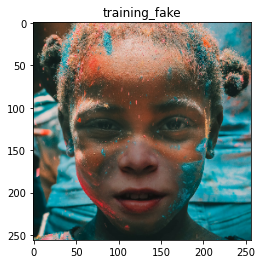

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[2].numpy().astype("uint8"))
    plt.title(class_names[label_batch[2]])

In [7]:
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Define paths
train_dir = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face/'
train_real_dir = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_real'
train_fake_dir = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake'
batch_size = 32
image_size = 256
# channels = 3
# Function to load and preprocess images
def load_and_preprocess_image(image_path, image_size):
    # Load image and resize
    image = load_img(image_path, target_size=(image_size, image_size))
    # Convert to numpy array
    image = img_to_array(image)
    # Rescale pixel values to [0, 1]
    image = image / 255.0
    return image

# Function to load and preprocess dataset
def load_and_preprocess_dataset(directory, image_size, batch_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_seed=42):
    images = []
    labels = []
    
    # Load real images
    real_images = os.listdir(os.path.join(directory, 'training_real'))
    for img_name in real_images:
        img_path = os.path.join(directory, 'training_real', img_name)
        image = load_and_preprocess_image(img_path, image_size)
        images.append(image)
        labels.append(1)  # Label 1 for real images
    
    # Load fake images
    fake_images = os.listdir(os.path.join(directory, 'training_fake'))
    for img_name in fake_images:
        img_path = os.path.join(directory, 'training_fake', img_name)
        image = load_and_preprocess_image(img_path, image_size)
        images.append(image)
        labels.append(0)  # Label 0 for fake images
    
    # Convert lists to numpy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='float32')
    
    # Shuffle dataset if specified
    if shuffle:
        np.random.seed(shuffle_seed)
        indices = np.random.permutation(len(images))
        images = images[indices]
        labels = labels[indices]
    
    # Split dataset into train, val, test
    split1 = int(len(images) * train_split)
    split2 = int(len(images) * (train_split + val_split))
    
    train_images, train_labels = images[:split1], labels[:split1]
    val_images, val_labels = images[split1:split2], labels[split1:split2]
    test_images, test_labels = images[split2:], labels[split2:]
    
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

# Load and preprocess dataset
train_images, train_labels, val_images, val_labels, test_images, test_labels = load_and_preprocess_dataset(train_dir, image_size, batch_size)

# Define the CNN model
model = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=batch_size,
    epochs=50,
    verbose=1
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')


Epoch 1/50
51/51 [==============================] - 24s 228ms/step - loss: 16.8584 - accuracy: 0.5257 - val_loss: 10.5136 - val_accuracy: 0.4265
Epoch 2/50
51/51 [==============================] - 11s 207ms/step - loss: 5.0916 - accuracy: 0.5809 - val_loss: 7.2468 - val_accuracy: 0.4216
Epoch 3/50
51/51 [==============================] - 11s 208ms/step - loss: 3.2714 - accuracy: 0.5790 - val_loss: 6.9893 - val_accuracy: 0.5539
Epoch 4/50
51/51 [==============================] - 11s 209ms/step - loss: 3.0301 - accuracy: 0.6048 - val_loss: 6.2954 - val_accuracy: 0.4608
Epoch 5/50
51/51 [==============================] - 11s 210ms/step - loss: 2.8101 - accuracy: 0.6213 - val_loss: 5.0345 - val_accuracy: 0.5539
Epoch 6/50
51/51 [==============================] - 11s 211ms/step - loss: 2.7123 - accuracy: 0.6293 - val_loss: 5.0685 - val_accuracy: 0.5686
Epoch 7/50
51/51 [==============================] - 11s 211ms/step - loss: 2.4699 - accuracy: 0.6581 - val_loss: 3.9162 - val_accuracy: 0.52

In [9]:
train_ds, val_ds, test_ds=splitting_dataset_tf(dataset)

In [10]:
print(len(train_ds),len(val_ds),len(test_ds))

51 6 7


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [14]:
channels = 3
input_shape = (batch_size,image_size, image_size,channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),
    
])

model.build(input_shape=input_shape)



In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=600,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/600
51/51 [==============================] - 18s 191ms/step - loss: 0.7570 - accuracy: 0.5172 - val_loss: 0.7046 - val_accuracy: 0.4740
Epoch 2/600
51/51 [==============================] - 3s 58ms/step - loss: 0.7001 - accuracy: 0.5135 - val_loss: 0.7653 - val_accuracy: 0.4792
Epoch 3/600
51/51 [==============================] - 3s 58ms/step - loss: 0.7070 - accuracy: 0.5306 - val_loss: 0.6933 - val_accuracy: 0.5208
Epoch 4/600
51/51 [==============================] - 3s 58ms/step - loss: 0.6958 - accuracy: 0.5092 - val_loss: 0.6934 - val_accuracy: 0.5208
Epoch 5/600
51/51 [==============================] - 3s 58ms/step - loss: 0.7022 - accuracy: 0.4920 - val_loss: 0.6946 - val_accuracy: 0.5208
Epoch 6/600
51/51 [==============================] - 3s 58ms/step - loss: 0.6999 - accuracy: 0.5233 - val_loss: 0.7335 - val_accuracy: 0.4792
Epoch 7/600
51/51 [==============================] - 3s 58ms/step - loss: 0.7008 - accuracy: 0.4828 - val_loss: 0.6935 - val_accuracy: 0.5104
Epoc

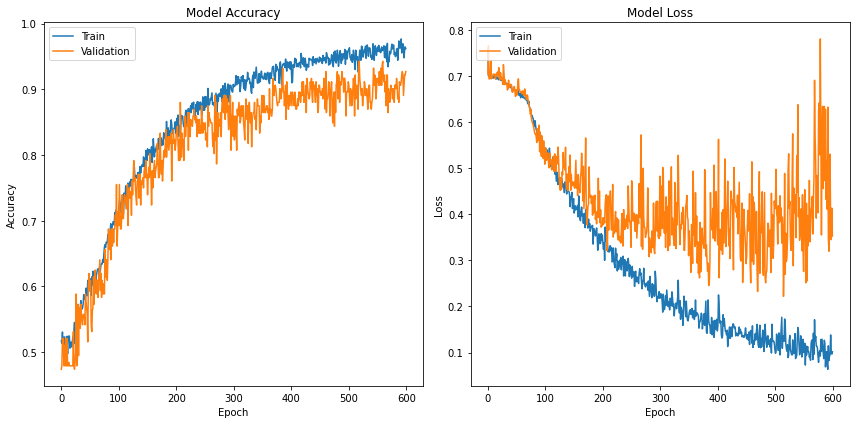

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'history' is the result from the model.fit()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



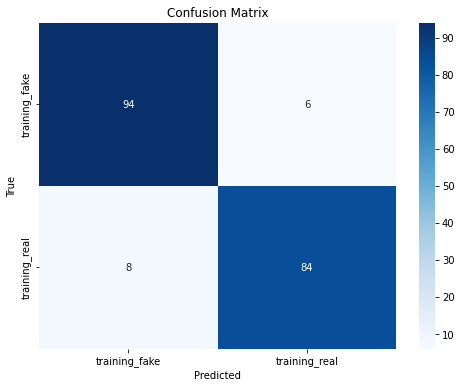

Classification Report:
                precision    recall  f1-score   support

training_fake       0.92      0.94      0.93       100
training_real       0.93      0.91      0.92        92

     accuracy                           0.93       192
    macro avg       0.93      0.93      0.93       192
 weighted avg       0.93      0.93      0.93       192



In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for _, y in val_ds], axis=0)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


In [19]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 7s 24ms/step - loss: 0.5469 - accuracy: 0.8839


In [20]:
scores_train = model.evaluate(train_ds)
print(f"Training Accuracy: {scores_train[1]*100:.2f}%")


51/51 [==============================] - 1s 19ms/step - loss: 0.1368 - accuracy: 0.9516
Training Accuracy: 95.16%


PREDICTION:
Expected Label:training_fake                  
Predicted Label:training_fake                  


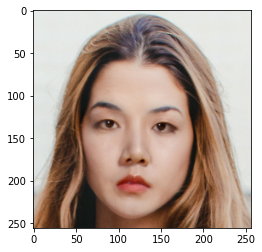

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def print_prediction(image, expected_label, predicted_label):
    print("PREDICTION:") 
    print("Expected Label:\033[1m{:<30}\033[0m ".format(expected_label))  # Bold expected label
    print("Predicted Label:\033[1m{:<30}\033[0m ".format(predicted_label))  # Bold predicted label

    plt.imshow(image)
    plt.show()

for image_batch, label_batch in dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    expected_label = class_names[first_label]
    batch_pred = model.predict(image_batch)
    predicted_label = class_names[np.argmax(batch_pred[0])]
    
    print_prediction(first_image, expected_label, predicted_label)


In [22]:
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

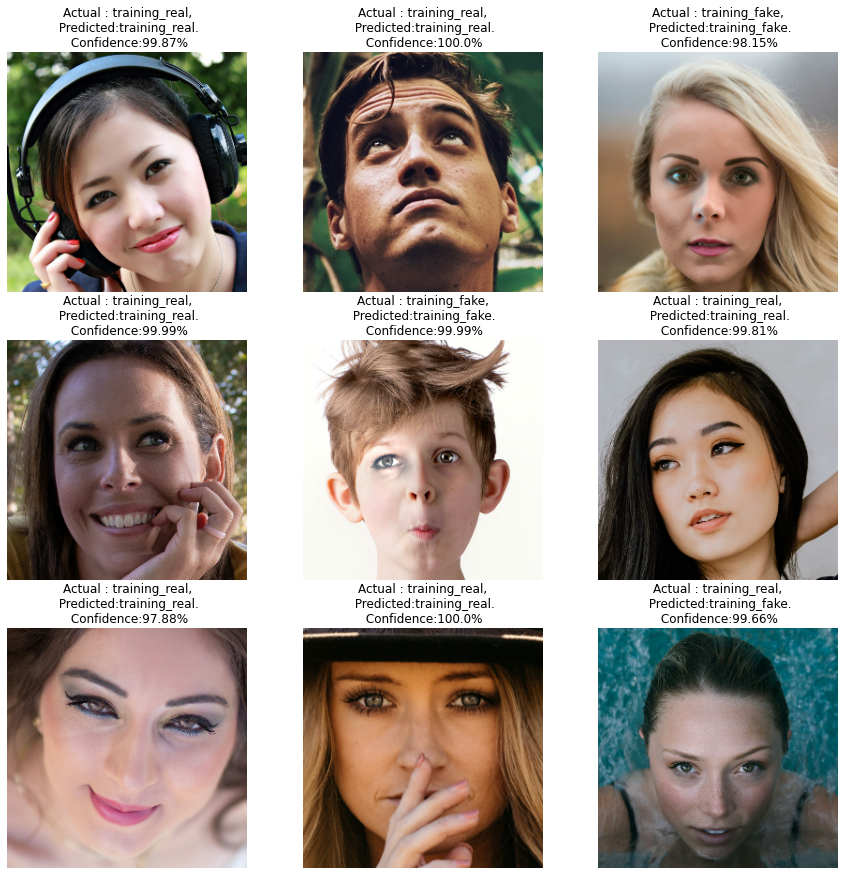

In [23]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = pred(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        
        plt.axis("off")

In [24]:
model.save("model.h5")